<h1 align='center'>Stroke Prediction</h1> 

В данной работе я проанализирую данные и попробую предсказать возникновение инсульта. <br>
Также в процессе анализа данных будут проведены действия направленные на улчшения работы модели

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, mannwhitneyu
from sklearn.impute import KNNImputer
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,confusion_matrix

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
%config IPCompleter.greedy=True

# Описание полей данных
<hr>
<ul>
    <li> id - id    
    <li> gender - пол
    <li> age - возраст
    <li> hypertension - наличие гипертонии
    <li> heart_disease - наличие заболеваний сердца
    <li> ever_married - в браке
    <li> work_type - тип работы
    <li> Residence_type - место проживания
    <li> avg_glucose_level - средний уровень глюкозы
    <li> bmi - индекс массы тела
    <li> smoking_status - наличие сигаретной зависимости
    <li> stroke - наличие инсульта    
<ul/>

In [4]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.shape

(5110, 12)

In [5]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Предобработка и визуализация данных

Видим, что у нас есть пропущенные значения

In [6]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
data = data.drop('id', axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [9]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Можно заметить, что минимальнй возраст в выборке составляет около <b>30</b> дней

In [10]:
data.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [11]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Также считаю, что из данных можно удалить <b>единственный</b> объект с неизвестным полом

In [12]:
data = data[data.gender != 'Other']

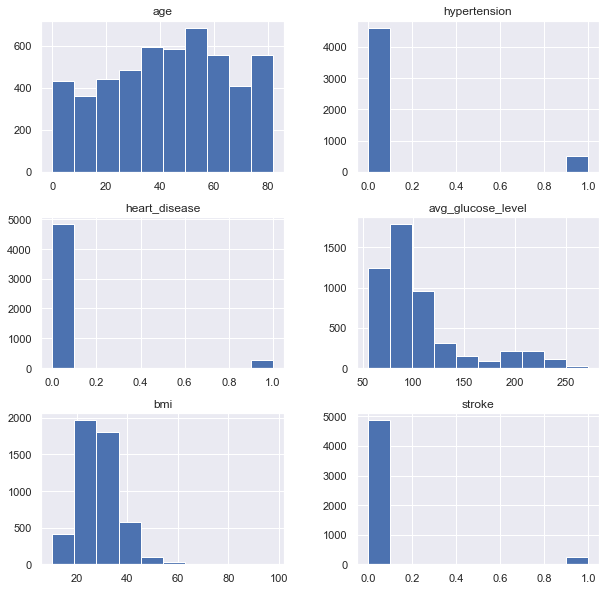

In [13]:
data.hist(figsize=(10, 10))
plt.show()

Заметим, что числовые и не бинарные значения имеют 'хвосты' справа <br>
А также увидим явный дисбаланс людей с заболеванием и без него

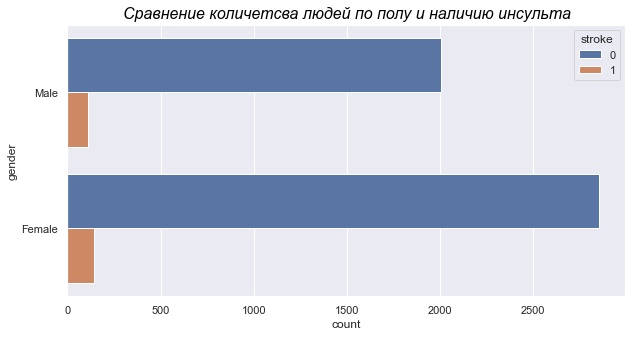

In [14]:
plt.figure(figsize=(10,5))
plt.title('Сравнение количетсва людей по полу и наличию инсульта', color='black', fontsize=16, fontstyle='italic')
sns.countplot(data=data, y='gender', hue='stroke')
plt.show()

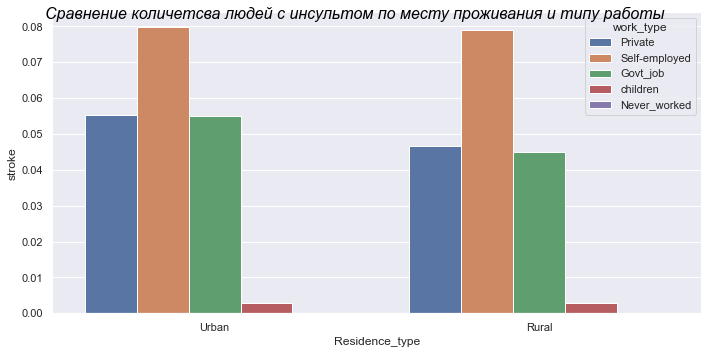

In [15]:
gr_1 = sns.catplot(data=data, x='Residence_type', y='stroke', hue='work_type', kind='bar', ci=False,
            height=5, aspect=2, legend_out=False)
gr_1.fig.suptitle('Сравнение количетсва людей с инсультом по месту проживания и типу работы', color='black', fontsize=16, fontstyle='italic')
plt.show()

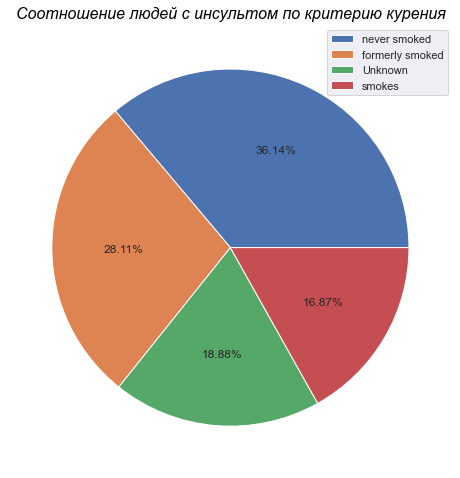

In [16]:
status_count = data[data.stroke == 1].smoking_status.value_counts().values
status_name = data[data.stroke == 1].smoking_status.value_counts().index

plt.figure(figsize=(8,10))
plt.title('Соотношение людей с инсультом по критерию курения', color='black', fontsize=16, fontstyle='italic')
plt.pie(x=status_count, autopct='%1.2f%%')
plt.legend(status_name)
plt.show()

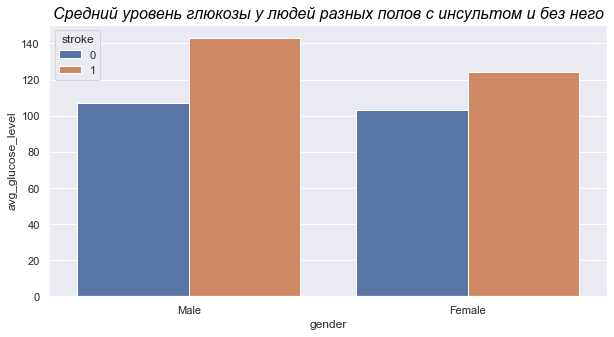

In [17]:
plt.figure(figsize=(10,5))
plt.title('Средний уровень глюкозы у людей разных полов с инсультом и без него', color='black', fontsize=16, fontstyle='italic')
sns.barplot(data=data, x='gender', y='avg_glucose_level', hue='stroke', ci=False)
plt.show()

Сильных корреляций в наших числовых данных не наблюдается

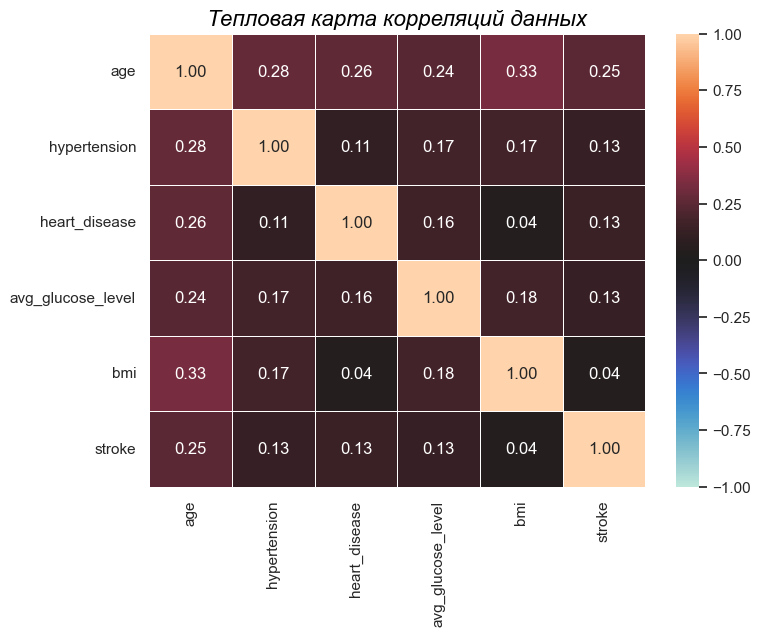

In [18]:
plt.figure(figsize=(8,6), dpi=100)
plt.title('Тепловая карта корреляций данных', color='black', fontsize=16, fontstyle='italic')
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=.5, vmin=-1, center=0, vmax=1)
plt.show()

Теперь восстановим наши пропущенные значения признака 'bmi', для этого будем использовать метод ближайших соседей, <br>
но для начала закодируем наши категориальные переменные

In [19]:
data_encode = pd.DataFrame()

data_encode['is_Male'] = data.gender.apply(lambda x: 1 if x == 'Male' else 0)
data_encode[['age','hypertension','heart_disease','avg_glucose_level']] = data[['age','hypertension','heart_disease','avg_glucose_level']]
data_encode['ever_married'] = data.ever_married.apply(lambda x: 1 if x == 'Yes' else 0)
data_encode['is_Urban'] = data.Residence_type.apply(lambda x: 1 if x == 'Urban' else 0)
data_encode = pd.concat([data_encode, pd.get_dummies(data.work_type)], axis=1)
data_encode = pd.concat([data_encode, pd.get_dummies(data.smoking_status)], axis=1)
data_encode['bmi_imuted'] = data['bmi']

target = data.stroke

In [20]:
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(data_encode)

In [21]:
data_encode['bmi_imuted'] = imputed[0:,16]

Теперь проверим изменилось ли распределение нашего восстановленного признака в сравнении с оригинальным

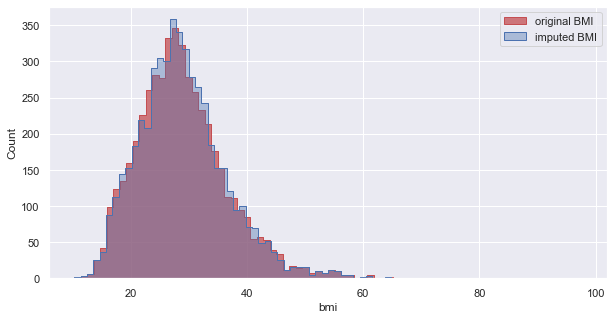

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='bmi', color='r', element='step')
sns.histplot(data=data_encode, x='bmi_imuted', color='b', element='step', alpha=0.4)
plt.legend(['original BMI','imputed BMI'])
plt.show()

Судя по гистограмме, выборки не различаются значительно <br>
Теперь убедимся, что данные имеют ненормальное распределение, <br>
но т.к тест Шапиро-Уилка не может принять больше 5000 значений, будем использовать бутстреп

In [23]:
def bootsrap_distrib(k, data):
    mean_p = np.array([])
    for i in range(k):
        boot = np.random.choice(data, size=2500)
        mean_p = np.append(mean_p, shapiro(boot).pvalue)
    print(f'P-value {mean_p.mean()}')

In [24]:
bootsrap_distrib(100, data[data.bmi.isna() == False].bmi)

P-value 1.7355485115670965e-22


In [25]:
bootsrap_distrib(100, data_encode.bmi_imuted)

P-value 5.048474184542149e-22


Мы убеждаемся, что наши выборки имеют ненормальное распределение, значит для сравнение средних будем использовать непараметрический критерий

<b> Нулевая гипотеза H0: средние значение выборок равны 

In [26]:
mannwhitneyu(data[data.bmi.isna() == False].bmi, data_encode.bmi_imuted)

MannwhitneyuResult(statistic=12457385.0, pvalue=0.5798322649565195)

P-значение больше 0.05, мы принимаем нулевую гипотезу теста Манна-Уитни о равенстве средних

Можем сделать вывод, что восстановленые данные значимо не отличаются от оригинальных 

# Устранение дисбаланса классов

## SMOTE-ENN

Метод SMOTE-ENN используют комбинацию оверсемплинга и андерсемплинга. Сначала применяется метод SMOTE для создания синтетических <br>
примеров в миноритарном классе, затем удаляются выбросы и шумы из полученных данных с помощью метода Edited Nearest Neighbors (ENN)

In [27]:
enn = EditedNearestNeighbours(sampling_strategy='not majority')

In [28]:
oversample = SMOTEENN(sampling_strategy='minority', enn=enn)

In [29]:
data_encode_os, target_os = oversample.fit_resample(data_encode, target)

In [30]:
target_os.value_counts()

0    4860
1    4580
Name: stroke, dtype: int64

# Построение модели

Для улучшение модели логистической регрессии стоит нормализовать наши данные

In [31]:
scaler = MinMaxScaler()

In [32]:
data_encode_os[['age','avg_glucose_level','bmi_imuted']] = scaler.fit_transform(data_encode_os[['age','avg_glucose_level','bmi_imuted']])

Теперь разобьем наши данные на тренировочные и тестовые

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data_encode_os, target_os, stratify=target_os)

In [34]:
lr_clf = LogisticRegression()

In [35]:
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [36]:
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

In [37]:
pred = lr_clf.predict(X_test)

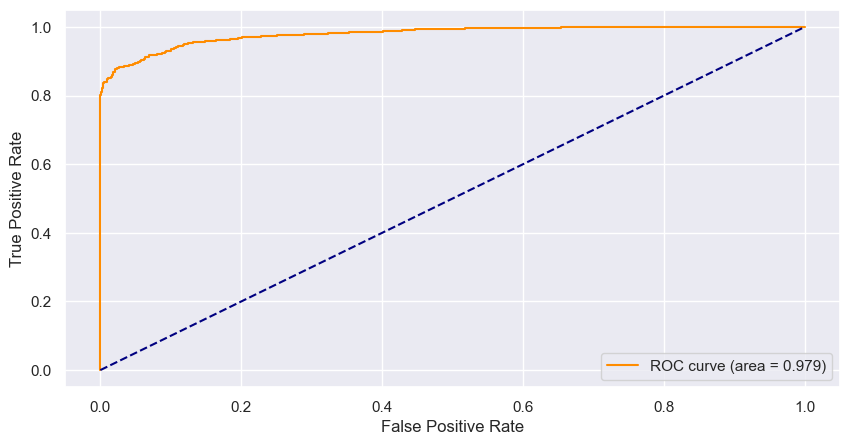

In [38]:
plt.figure(figsize=(10, 5), dpi=100)

fpr, tpr, _ = roc_curve(y_test,  pred_proba)
lr_auc = roc_auc_score(y_test, pred_proba)
plt.plot(fpr,tpr, color='darkorange', label='ROC curve (area = %.3f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

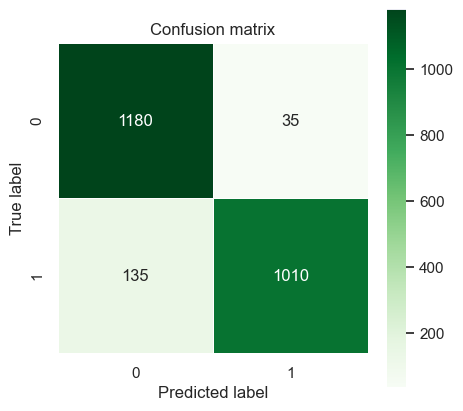

In [39]:
plt.figure(figsize=(5, 5), dpi=100)

plt.title('Confusion matrix')
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f', linewidths=.5,
            cmap='Greens', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Мы можем уменьшить количество ложноотрицательных ответов уменьшив стандартный порог (0.5) <br>
в логистической регрессии. А значит действительно больных людей мы найдем большей

In [40]:
pred_new = np.where(pred_proba > 0.2, 1, 0)

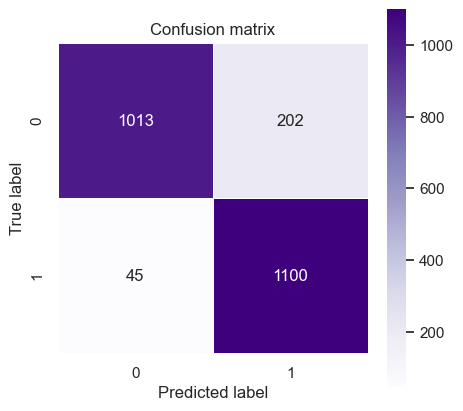

In [41]:
plt.figure(figsize=(5, 5), dpi=100)

plt.title('Confusion matrix')
sns.heatmap(confusion_matrix(y_test, pred_new), annot=True, fmt='.0f', linewidths=.5,
            cmap='Purples', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Можно резюмировать, что наша модель достаточно неплохо справилась с нашими данными, но стоит учесть тот факт, <br>
что большая часть минорного класса была сгенерирована синтетически